In [1]:
import torch
import numpy as np
import torchvision
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
from torch import nn
from dataset import CUB
from utils import *

device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
#data_root = '../data/CUB-200-2011'
data_root = '..'
model_name = 'vgg'
image_size = 224
torch.manual_seed(0)

In [2]:
if model_name == 'vgg':
    model = torchvision.models.vgg16_bn(pretrained = False).to(device)
elif model_name == 'alexnet':
    model = torchvision.models.alexnet(pretrained = False).to(device)
model.classifier[6] = nn.Linear(4096, 200).to(device)
model.load_state_dict(torch.load(f'model/{model_name}_CUB.pth'))

model.eval()
testset = CUB(data_root, normalization=True, train_test='test')


/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Plotting the single image


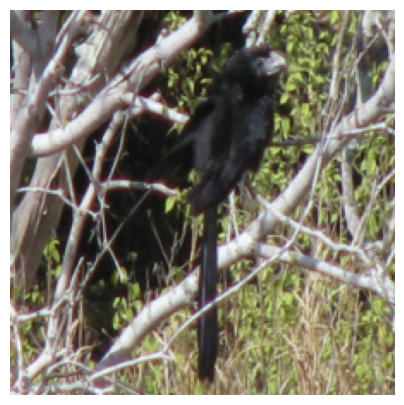

Top class:	3,	confidence = 1.000
Second class:	26,	confidence = 0.000


In [3]:
image_index = 3
image = testset[image_index][0].view(1,3,224,224).to(device)


transform = transforms.Compose(
    [transforms.Resize((image_size, image_size)),
     transforms.ToTensor(),
     transforms.Normalize(mean = [0.485, 0.456, 0.406], 
                          std = [0.229, 0.224, 0.225])
])

image = Image.open('./paper_imgs/figure_4/Groove_Billed_Ani_0068_1538.jpg')
image = image.convert('RGB')
image = transform(image).view(1,3,224,224).to(device)

plot_tensor_image(image)

with torch.no_grad():
    prob = torch.softmax(model(image),dim=1)[0]
    argsort=prob.argsort()
    t1 = argsort[-1]
    t2 = argsort[-2]
print("Top class:\t%d,\tconfidence = %.3f\nSecond class:\t%d,\tconfidence = %.3f"\
      %(t1, prob[t1],t2, prob[t2]))

# Test XGradCAM using mode='XC'
gradcam = get_saliency(model, image, t2, mode='GC', softmax=False)
contrastive_gradcam = get_saliency(model, image, t2, mode='GC', softmax=True)

# gradcam = get_saliency(model, image, t2, mode='XC', softmax=False)
# contrastive_gradcam = get_saliency(model, image, t2, mode='XC', softmax=True)

# blur the negative areas
blurred_image, contrastive_blurred_image = equal_blur(image, gradcam, contrastive_gradcam, mode='positive')
with torch.no_grad():
    contrastive_blurred_prob = torch.softmax(model(contrastive_blurred_image),dim=1)[0]
    blurred_prob = torch.softmax(model(blurred_image),dim=1)[0]

When the model is not confident given the sample, i.e. $p_{t_1} = p_{max}$ isn't close to 1, then difference between between contrastiveness among classes cannot be overlooked. Let $r=p_{t_1}/(p_{t_1}+p_{t_2})$

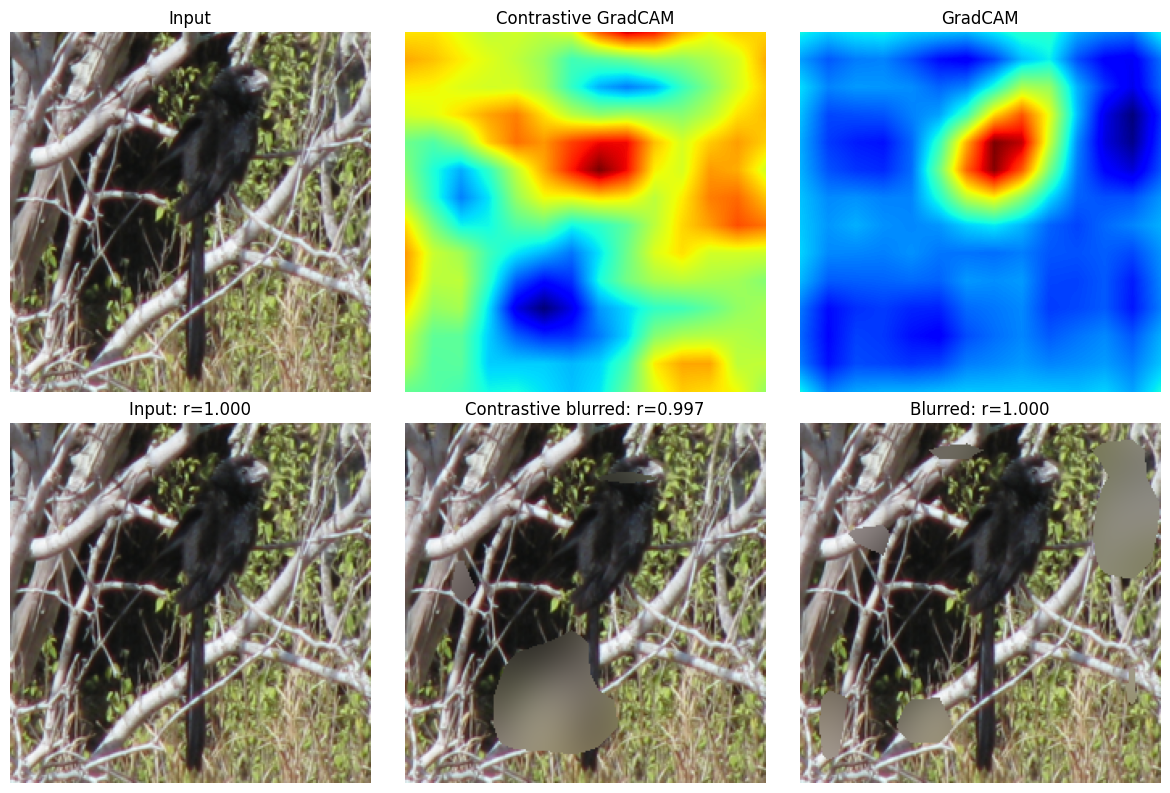

In [4]:
fig, ax = plt.subplots(2,3,figsize=(12,8))
ax = ax.flatten()
ax[0].imshow(denorm(image).detach().cpu().numpy().squeeze().transpose((1,2,0)))
ax[0].set_title('Input')
ax[1].imshow(contrastive_gradcam.detach().cpu().squeeze().numpy(), cmap='jet')
ax[1].set_title('Contrastive GradCAM')
ax[2].imshow(gradcam.detach().cpu().squeeze().numpy(), cmap='jet')
ax[2].set_title('GradCAM')
ax[3].imshow(denorm(image).detach().cpu().numpy().squeeze().transpose((1,2,0)))
ax[3].set_title('Input: r=%.3f'%(prob[t1]/(prob[t2]+prob[t1])))
ax[4].imshow(denorm(contrastive_blurred_image).detach().cpu().numpy().squeeze().transpose((1,2,0)))
ax[4].set_title('Contrastive blurred: r=%.3f'%(contrastive_blurred_prob[t1]/(contrastive_blurred_prob[t2]+contrastive_blurred_prob[t1])))
ax[5].imshow(denorm(blurred_image).detach().cpu().numpy().squeeze().transpose((1,2,0)))
ax[5].set_title('Blurred: r=%.3f'%(blurred_prob[t1]/(blurred_prob[t2]+blurred_prob[t1])))
for i in range(6):
    ax[i].axis('off')
plt.tight_layout()
plt.show()